# Estandarización vs. Normalización vs. Escalado Robusto

En este notebook, exploraremos tres técnicas comunes de preprocesamiento de características numéricas en Machine Learning:

1.  **Estandarización (`StandardScaler`)**: Transforma los datos para que tengan una media de 0 y una desviación estándar de 1.
2.  **Normalización (`MinMaxScaler`)**: Escala los datos a un rango específico, comúnmente [0, 1].
3.  **Escalado Robusto (`RobustScaler`)**: Escala los datos utilizando estadísticas que son robustas a los outliers, como el rango intercuartílico.

Veremos cómo cada técnica afecta a los datos y cómo la falta de un preprocesamiento adecuado puede impactar el rendimiento de un modelo de `LinearRegression`.

## 1. Importación de librerías y creación de datos

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression

# Configuramos el estilo de las gráficas
sns.set_theme(style="whitegrid")

Vamos a generar un dataset sintético para ejemplificar las distintas transformaciones.

In [13]:
# Generamos datos sintéticos
# 'feature1' tendrá una escala pequeña y 'feature2' una escala mucho mayor.
np.random.seed(42)
feature1 = np.random.uniform(0, 10, 100)
feature2 = np.random.uniform(50, 500, 100)

# El target (variable objetivo) es una combinación lineal de las características + ruido
target = 2 * feature1 + 0.5 * feature2 + np.random.normal(0, 25, 100)

# Creamos un DataFrame para facilitar la manipulación
data = pd.DataFrame({
    'feature1': feature1,
    'feature2': feature2,
    'target': target
})

# Añadimos un outlier para ver cómo afecta a los escaladores
data.loc[100] = [8, 1500, 800] # Outlier

print("Primeras 5 filas de los datos originales:")
print(data.head())
print("\nEstadísticas descriptivas de los datos originales:")
print(data.describe())

Primeras 5 filas de los datos originales:
   feature1    feature2      target
0  3.745401   64.143134   22.561751
1  9.507143  336.384685  193.012971
2  7.319939  191.460191  117.696786
3  5.986585  278.856811  133.542790
4  1.560186  458.404913  278.967192

Estadísticas descriptivas de los datos originales:
         feature1     feature2      target
count  101.000000   101.000000  101.000000
mean     4.734463   286.162649  155.560978
std      2.978120   179.178687   99.007271
min      0.055221    53.128459   -7.611322
25%      1.959829   158.924872   90.446550
50%      4.722149   278.856811  131.781330
75%      7.319939   400.943996  212.226814
max      9.868869  1500.000000  800.000000


## 2. Visualización de los datos originales

Observemos la distribución de nuestras características. Es evidente que `feature2` opera en una escala mucho mayor que `feature1`, y hemos añadido un outlier que exagera esta diferencia.

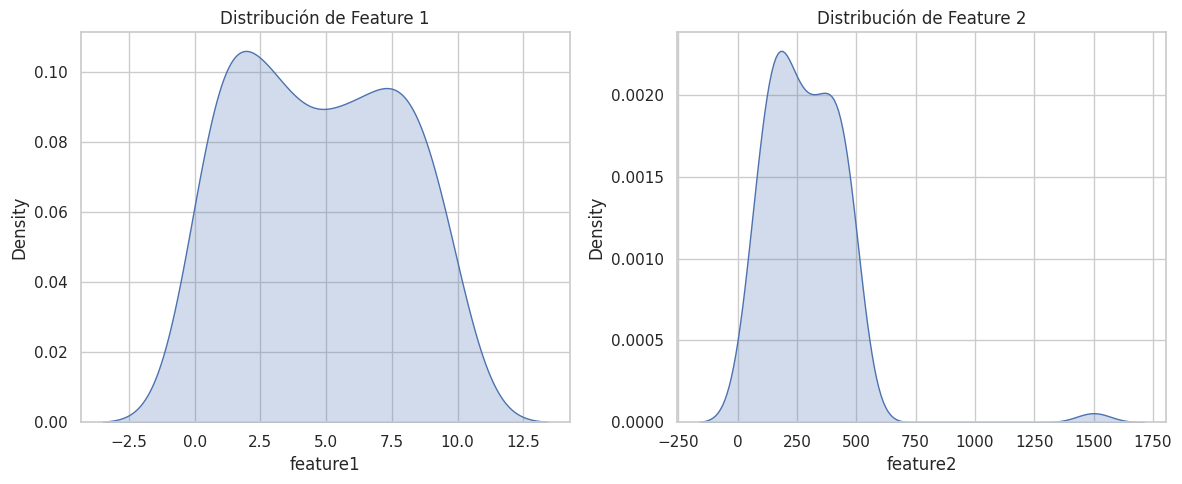

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title('Distribución de Feature 1')
sns.kdeplot(data['feature1'], ax=ax1, fill=True)

ax2.set_title('Distribución de Feature 2')
sns.kdeplot(data['feature2'], ax=ax2, fill=True)

plt.tight_layout()
plt.show()

Visualizamos la misma información usando diagramas caja o box-plots

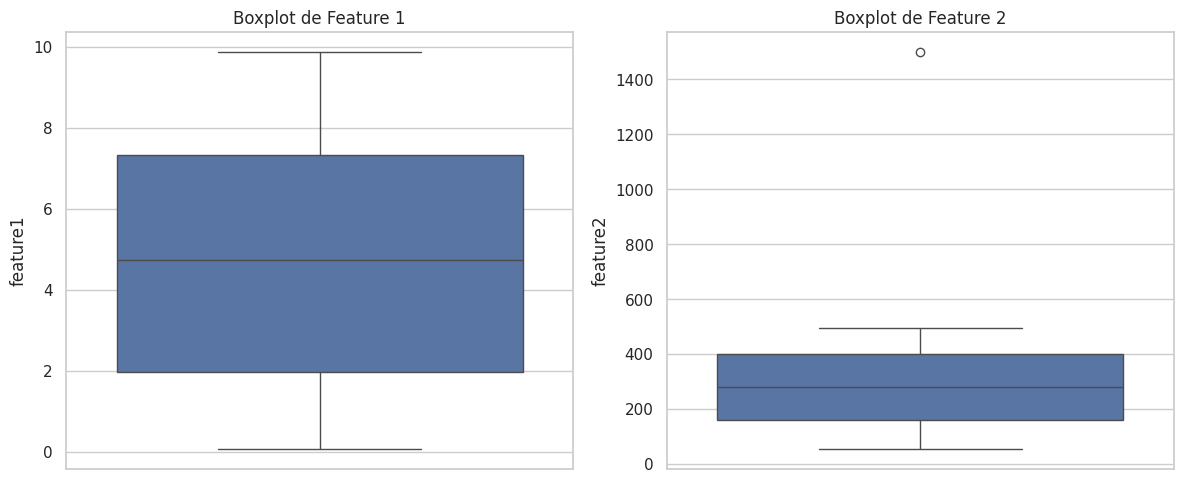

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title('Boxplot de Feature 1')
sns.boxplot(y=data['feature1'], ax=ax1)

ax2.set_title('Boxplot de Feature 2')
sns.boxplot(y=data['feature2'], ax=ax2)

plt.tight_layout()
plt.show()

## 3. Modelo de regresión lineal SIN preprocesamiento

Entrenaremos un modelo de Regresión Lineal directamente con los datos originales. En modelos como la regresión lineal, las características con escalas más grandes pueden dominar el proceso de aprendizaje, llevando a que el modelo les dé una importancia desproporcionada.

In [16]:
# Separamos características (X) y objetivo (y)
X_raw = data[['feature1', 'feature2']]
y = data['target']

# Entrenamos el modelo
model_raw = LinearRegression()
model_raw.fit(X_raw, y)

# Extraemos los coeficientes (la importancia que el modelo le da a cada característica)
coefs_raw = pd.DataFrame(
    model_raw.coef_,
    X_raw.columns,
    columns=['Coeficiente']
)

print("Coeficientes del modelo SIN preprocesamiento:")
print(coefs_raw)

Coeficientes del modelo SIN preprocesamiento:
          Coeficiente
feature1     1.107825
feature2     0.534369


**Observación:** Aunque creamos el target con `2 * feature1` y `0.5 * feature2`, el modelo le ha dado un coeficiente mucho mayor a `feature2`. Esto se debe a su escala numérica superior, que "engaña" al modelo haciéndole creer que es más importante de lo que realmente es.

## 4. Aplicando las técnicas de escalado

### 4.1. Estandarización (StandardScaler)

Centra los datos en una media de 0 y una desviación estándar de 1. Es sensible a los outliers, ya que la media y la desviación estándar se ven afectadas por ellos.

In [17]:
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X_raw)
X_standard = pd.DataFrame(X_standard, columns=X_raw.columns)

print("Estadísticas después de StandardScaler:")
print(X_standard.describe().round(4))

Estadísticas después de StandardScaler:
       feature1  feature2
count  101.0000  101.0000
mean     0.0000   -0.0000
std      1.0050    1.0050
min     -1.5790   -1.3071
25%     -0.9363   -0.7137
50%     -0.0042   -0.0410
75%      0.8725    0.6438
max      1.7326    6.8082


### 4.2. Normalización (MinMaxScaler)

Escala los datos al rango [0, 1]. Es muy sensible a los outliers, ya que el valor mínimo y máximo determinan el escalado. El outlier hará que la mayoría de los datos se "compriman" en un rango pequeño.

In [18]:
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X_raw)
X_minmax = pd.DataFrame(X_minmax, columns=X_raw.columns)

print("Estadísticas después de MinMaxScaler:")
print(X_minmax.describe().round(4))

Estadísticas después de MinMaxScaler:
       feature1  feature2
count  101.0000  101.0000
mean     0.4768    0.1611
std      0.3035    0.1238
min      0.0000    0.0000
25%      0.1941    0.0731
50%      0.4756    0.1560
75%      0.7403    0.2404
max      1.0000    1.0000


### 4.3. Escalado robusto (RobustScaler)

Usa el rango intercuartílico para escalar, lo que lo hace robusto a los outliers. Es la mejor opción cuando se sospecha la presencia de valores atípicos.

In [19]:
scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(X_raw)
X_robust = pd.DataFrame(X_robust, columns=X_raw.columns)

print("Estadísticas después de RobustScaler:")
print(X_robust.describe().round(4))

Estadísticas después de RobustScaler:
       feature1  feature2
count  101.0000  101.0000
mean     0.0023    0.0302
std      0.5556    0.7403
min     -0.8707   -0.9327
25%     -0.5153   -0.4955
50%      0.0000    0.0000
75%      0.4847    0.5045
max      0.9602    5.0456


### 4.4. Visualización comparativa

Comparemos las distribuciones de `feature2` después de cada transformación. Notaremos cómo el outlier afecta a cada una de manera diferente.

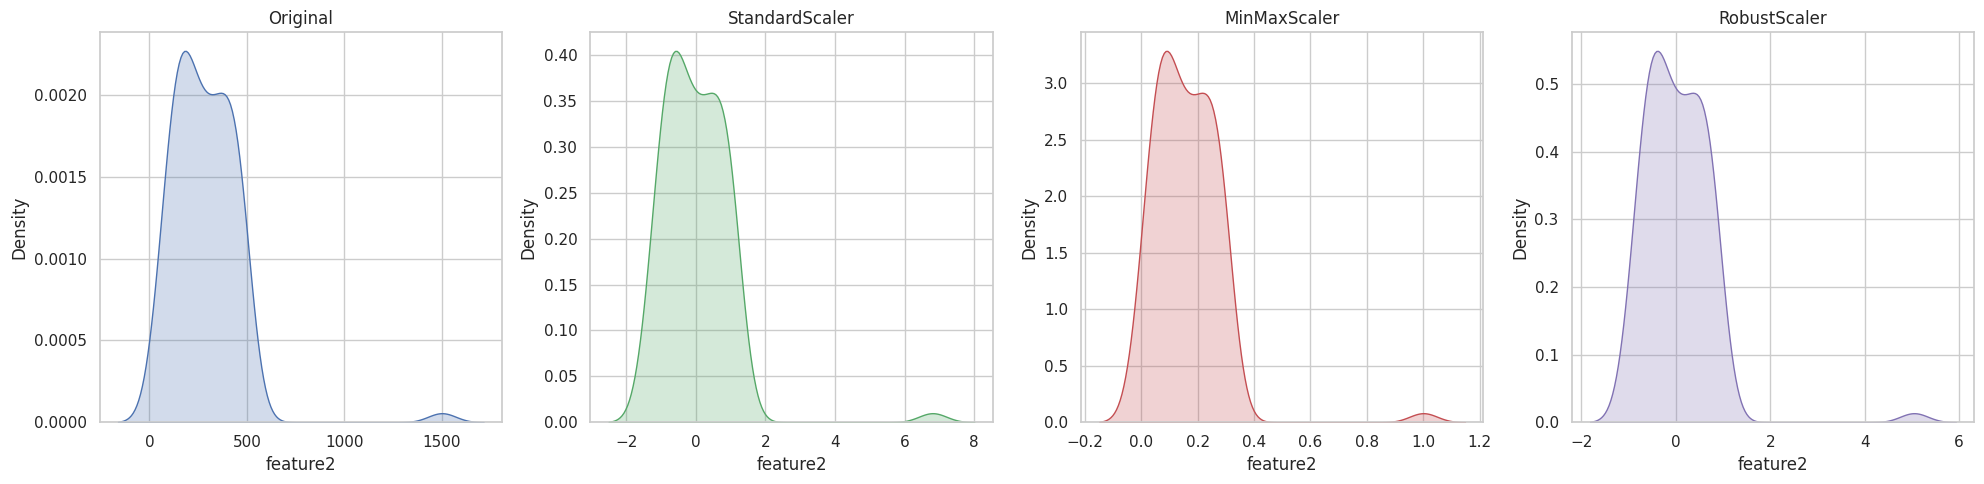

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))

ax1.set_title('Original')
sns.kdeplot(data['feature2'], ax=ax1, fill=True)

ax2.set_title('StandardScaler')
sns.kdeplot(X_standard['feature2'], ax=ax2, fill=True, color='g')

ax3.set_title('MinMaxScaler')
sns.kdeplot(X_minmax['feature2'], ax=ax3, fill=True, color='r')

ax4.set_title('RobustScaler')
sns.kdeplot(X_robust['feature2'], ax=ax4, fill=True, color='m')

plt.tight_layout()
plt.show()

**Análisis de la gráfica:**
- **Original**: La distribución está dominada por el outlier a la derecha.
- **StandardScaler**: La distribución sigue sesgada por el outlier.
- **MinMaxScaler**: La mayoría de los datos están aplastados cerca de 0, porque el outlier se ha convertido en el valor 1 y ha estirado todo el rango.
- **RobustScaler**: Muestra la distribución de los datos "normales" de forma mucho más clara, ya que el efecto del outlier ha sido mitigado.

## 5. Modelos de regresión lineal CON preprocesamiento

Ahora, entrenaremos un modelo para cada conjunto de datos preprocesado y compararemos los coeficientes.

In [21]:
# Modelo con StandardScaler
model_standard = LinearRegression()
model_standard.fit(X_standard, y)
coefs_standard = model_standard.coef_

# Modelo con MinMaxScaler
model_minmax = LinearRegression()
model_minmax.fit(X_minmax, y)
coefs_minmax = model_minmax.coef_

# Modelo con RobustScaler
model_robust = LinearRegression()
model_robust.fit(X_robust, y)
coefs_robust = model_robust.coef_

# Comparemos los coeficientes
coefs_comparison = pd.DataFrame({
    'Sin Escalar': model_raw.coef_,
    'StandardScaler': coefs_standard,
    'MinMaxScaler': coefs_minmax,
    'RobustScaler': coefs_robust,
}, index=X_raw.columns)

print("Comparación de Coeficientes de los Modelos")
print(coefs_comparison.round(2))

Comparación de Coeficientes de los Modelos
          Sin Escalar  StandardScaler  MinMaxScaler  RobustScaler
feature1         1.11            3.28         10.87          5.94
feature2         0.53           95.27        773.16        129.33


## 6. Conclusiones y Recomendaciones

Al escalar las características, los coeficientes del modelo ahora reflejan mejor la importancia relativa de cada una. Los coeficientes de los modelos escalados son mucho más grandes que los del modelo original. Esto se debe a que, después del escalado, un cambio de "una unidad" en `feature1` o `feature2` tiene un impacto comparable en la predicción.

### ¿Cuándo usar cada técnica?

1.  **Estandarización (`StandardScaler`)**
    - **Cuándo usarla**: Es la técnica de escalado más común y suele ser la primera opción. Funciona bien cuando los datos tienen una distribución aproximadamente Gaussiana (normal). Es menos sensible a los outliers que la normalización, pero aún así se ve afectada.
    - **Algoritmos que se benefician**: Modelos que asumen que los datos están centrados en cero, como Regresión Lineal, Regresión Logística, Máquinas de Soporte Vectorial (SVM), Análisis de Componentes Principales (PCA) y K-Means.

2.  **Normalización (`MinMaxScaler`)**
    - **Cuándo usarla**: Cuando se necesita que los datos estén en un rango estricto, como [0, 1] o [-1, 1]. Es muy útil en algoritmos que no hacen suposiciones sobre la distribución de los datos, como K-Nearest Neighbors (KNN).
    - **Precaución**: Es muy sensible a los outliers. Un solo valor atípico puede comprimir la mayoría de los datos en un rango muy pequeño, afectando negativamente el rendimiento del modelo.
    - **Algoritmos que se benefician**: Redes Neuronales (especialmente en el procesamiento de imágenes, donde los píxeles se escalan a [0, 1]), y algoritmos de distancia como KNN.

3.  **Escalado Robusto (`RobustScaler`)**
    - **Cuándo usarla**: Es la mejor opción cuando el conjunto de datos contiene una cantidad significativa de **outliers**. Utiliza el rango intercuartílico (IQR) en lugar de la media/desviación estándar o el mínimo/máximo, por lo que ignora el efecto de los valores atípicos.
    - **Algoritmos que se benefician**: Prácticamente cualquier algoritmo sensible a la escala se beneficiará de `RobustScaler` si hay outliers presentes. Es una alternativa segura a `StandardScaler`.